In [197]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

In [198]:
df = pd.read_csv(r"Churn_Banking_Modeling.csv")

In [205]:
# nella creazione delle dummies vengono usati caratteri speciali nei nomi delle colonne, li rimpiazziamo
def clean_feature_names(df):
    df.columns = [col.replace(' ', '_').replace('[', '').replace(']', '').replace('<', '') for col in df.columns]
    return df

In [209]:
X = df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y = df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1}) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_res = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

X_train_res = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)
X_train_res, X_test = X_train.align(X_test, join='inner', axis=1)

count_ones = np.sum(y_test == 1)
print("Numero di volte che y_test è uguale a 1:", count_ones)

Numero di colonne in X originale: 296
Numero di volte che y_test è uguale a 1: 397


Dataset Normale, senza Sampling

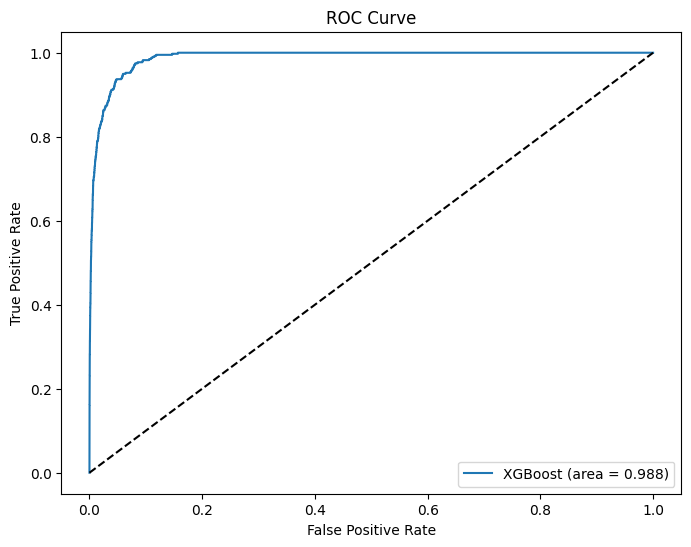

In [210]:
# Useremo sempre XGBoost
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_res, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='XGBoost (area = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [290]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4) #cambiamo lo split per vedere se i nostri dati overfittano
X_train = pd.get_dummies(X_train) #dummie encoder
X_test = pd.get_dummies(X_test)
#problema di corrispondenza delle dummies create, le colonne non coincidono in quanto alcuni valori di Domicilio e Residenza sono unici e vengono visualizzati solo una volta nel train o test set
# per ovviare al problema ricreiamo le colonne  non corrispondenti nei df dove mancano con tutti valori = 0
missing_columns_train = set(X_train_res.columns) - set(X_train.columns)
for col in missing_columns_train:
    X_train[col] = 0

missing_columns_test = set(X_train_res.columns) - set(X_test.columns)
for col in missing_columns_test:
    X_test[col] = 0

X_train = X_train[X_train_res.columns]
X_test = X_test[X_train_res.columns]

X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

# prediction usando il nostro classifier
y_pred_proba = model.predict_proba(X_test)[:, 1]

results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': y_pred_proba

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)


       y_test  y_pred_proba
17391       1      0.999978
13285       1      0.999939
16217       1      0.999913
6666        1      0.999901
6629        1      0.999866
...       ...           ...
55579       0      0.000388
71176       0      0.000387
15756       0      0.000387
19033       0      0.000387
48355       0      0.000387

[10000 rows x 2 columns]


In [291]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Numero di 'SI: nel nostro test set", count_ones)


Numero di 'SI' nei nostri 10k: 398
Numero di 'SI: nel nostro test set 398


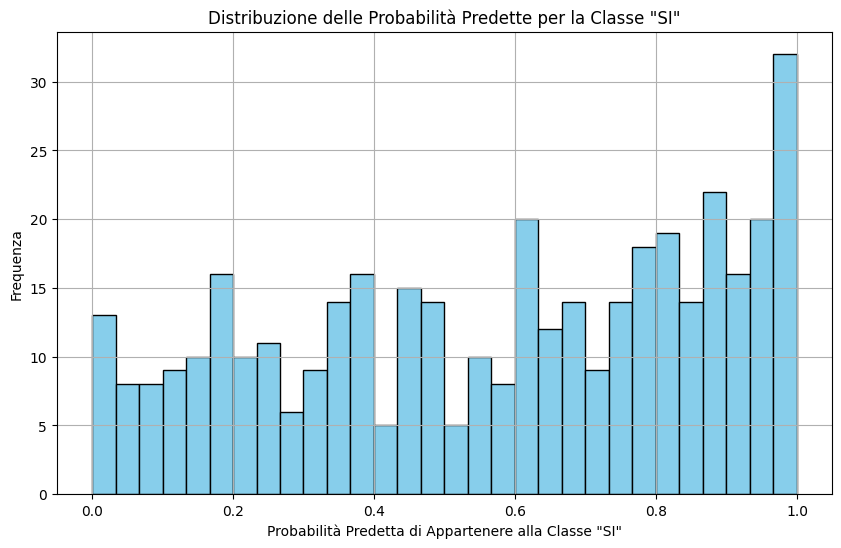

In [223]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

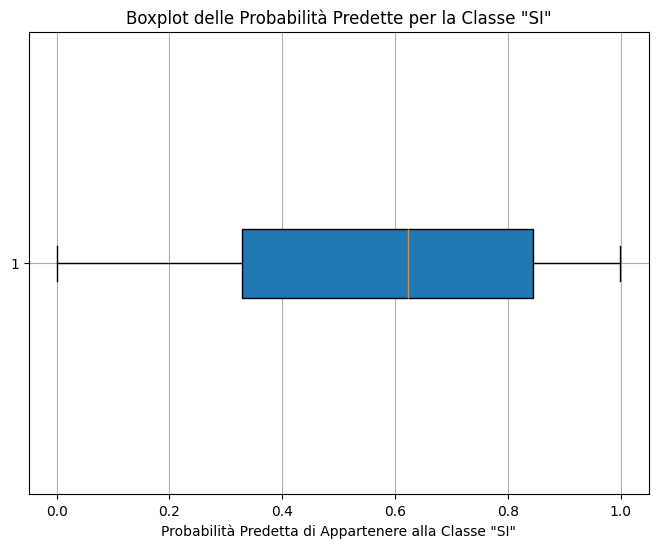

In [224]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()

UnderSampling

In [229]:
from imblearn.under_sampling import RandomUnderSampler
X = df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y = df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1})  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rus = RandomUnderSampler(sampling_strategy=0.03)  # rapporto 1:36
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
X_train_res = pd.get_dummies(X_train_res)
X_test = pd.get_dummies(X_test)
X_train_res = clean_feature_names(X_train_res)
X_test = clean_feature_names(X_test)

X_train_res, X_test = X_train_res.align(X_test, join='inner', axis=1)


In [230]:
print("Distribuzione delle classi nel dataset originale:")
print(df['Flag_Richiesta_Estinzione_cc'].value_counts())

print("Distribuzione delle classi nel dataset bilanciato:")
print(y_train_res.value_counts())

Distribuzione delle classi nel dataset originale:
Flag_Richiesta_Estinzione_cc
no    375386
si      1983
Name: count, dtype: int64
Distribuzione delle classi nel dataset bilanciato:
Flag_Richiesta_Estinzione_cc
0    52866
1     1586
Name: count, dtype: int64


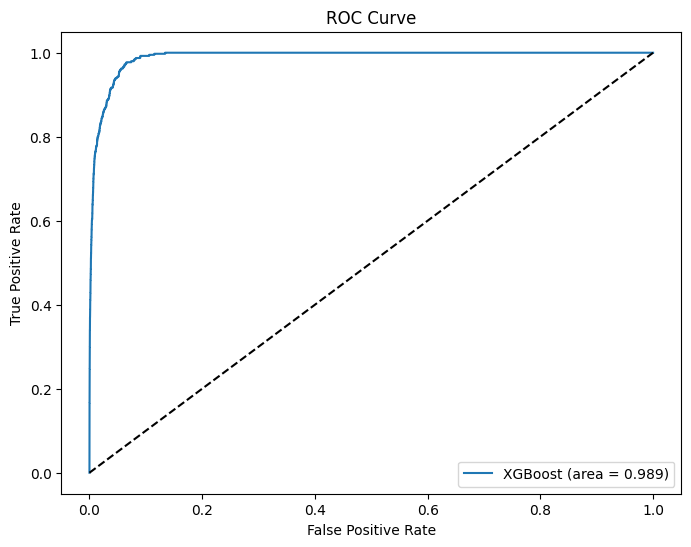

In [231]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_res, y_train_res)

y_pred_proba = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='XGBoost (area = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  # Linea diagonale tratteggiata
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [285]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=38) #cambiamo lo split per vedere se i nostri dati overfittano
X_train = pd.get_dummies(X_train) 
X_test = pd.get_dummies(X_test)

missing_columns_train = set(X_train_res.columns) - set(X_train.columns)
for col in missing_columns_train:
    X_train[col] = 0

missing_columns_test = set(X_train_res.columns) - set(X_test.columns)
for col in missing_columns_test:
    X_test[col] = 0

X_train = X_train[X_train_res.columns]
X_test = X_test[X_train_res.columns]

X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

# prediction usando il nostro classifier
y_pred_proba = model.predict_proba(X_test)[:, 1]

results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': y_pred_proba

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)



       y_test  y_pred_proba
5785        1      0.999999
6683        1      0.999928
16217       1      0.999913
40767       1      0.999906
27147       1      0.999884
...       ...           ...
32090       0      0.000430
40286       0      0.000430
32393       0      0.000429
51159       0      0.000429
45803       0      0.000428

[10000 rows x 2 columns]


In [286]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 385
Numero di 'SI: nel nostro test set 385


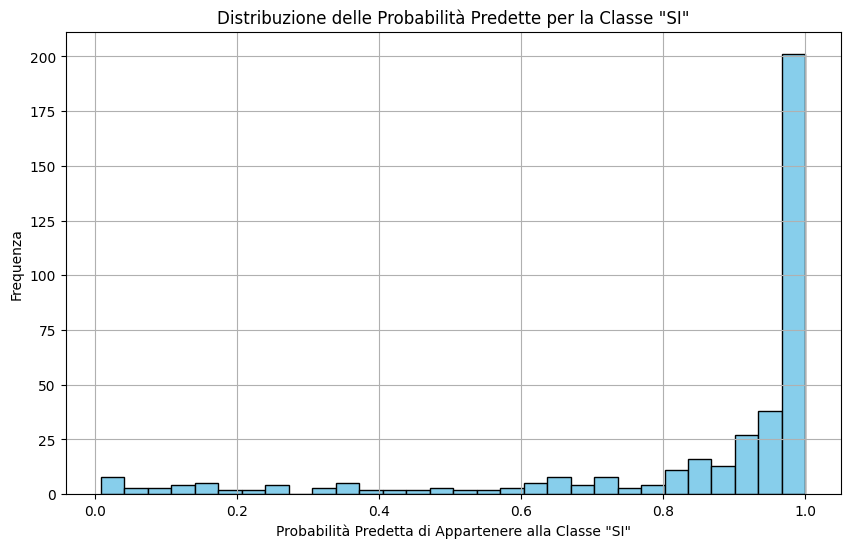

In [146]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

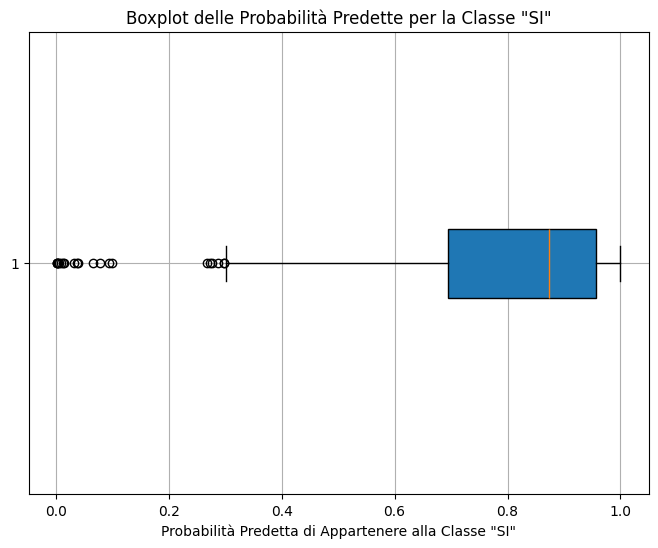

In [240]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()


OverSampling

In [244]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy=0.2)  
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)
X_train_res = pd.get_dummies(X_train_res)
X_test = pd.get_dummies(X_test)
X_train_res = clean_feature_names(X_train_res)
X_test = clean_feature_names(X_test)

X_train_res, X_test = X_train_res.align(X_test, join='inner', axis=1)


In [245]:
print("Distribuzione delle classi nel dataset originale:")
print(df['Flag_Richiesta_Estinzione_cc'].value_counts())

print("Distribuzione delle classi nel dataset bilanciato:")
print(y_train_res.value_counts())

Distribuzione delle classi nel dataset originale:
Flag_Richiesta_Estinzione_cc
no    375386
si      1983
Name: count, dtype: int64
Distribuzione delle classi nel dataset bilanciato:
Flag_Richiesta_Estinzione_cc
0    300314
1     60062
Name: count, dtype: int64


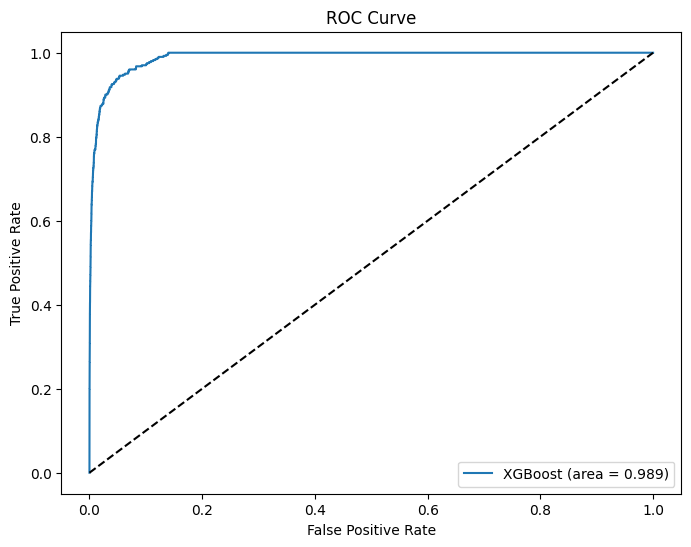

In [246]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_res, y_train_res)

y_pred_proba = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='XGBoost (area = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  # Linea diagonale tratteggiata
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [251]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31) #cambiamo lo split per vedere se i nostri dati overfittano
X_train = pd.get_dummies(X_train) 
X_test = pd.get_dummies(X_test)

missing_columns_train = set(X_train_res.columns) - set(X_train.columns)
for col in missing_columns_train:
    X_train[col] = 0

missing_columns_test = set(X_train_res.columns) - set(X_test.columns)
for col in missing_columns_test:
    X_test[col] = 0

X_train = X_train[X_train_res.columns]
X_test = X_test[X_train_res.columns]

X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

# prediction usando il nostro classifier
y_pred_proba = model.predict_proba(X_test)[:, 1]

results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': y_pred_proba

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)


       y_test  y_pred_proba
58350       1      0.999777
6564        1      0.999684
17678       1      0.999511
13317       1      0.998725
16647       1      0.998706
...       ...           ...
20070       0      0.000851
9617        0      0.000851
12352       0      0.000851
17847       0      0.000849
50241       0      0.000849

[10000 rows x 2 columns]


In [252]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 382
Numero di 'SI: nel nostro test set 382


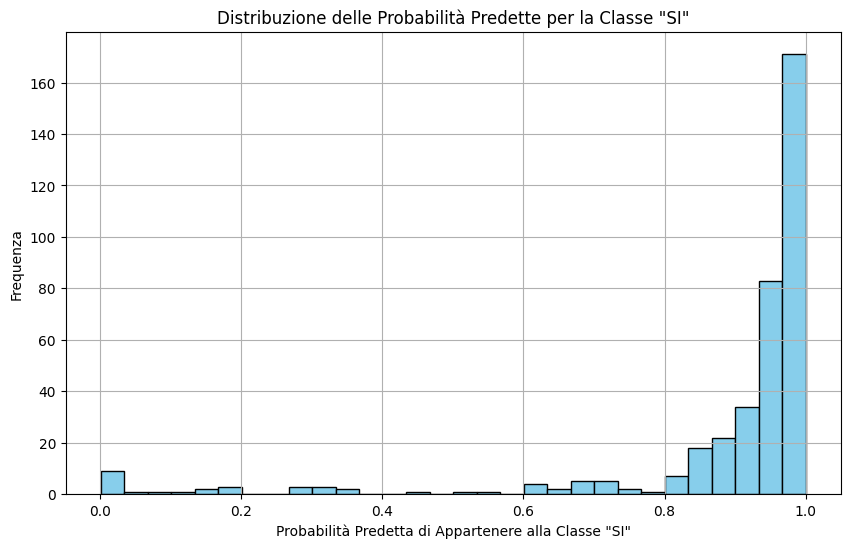

In [253]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

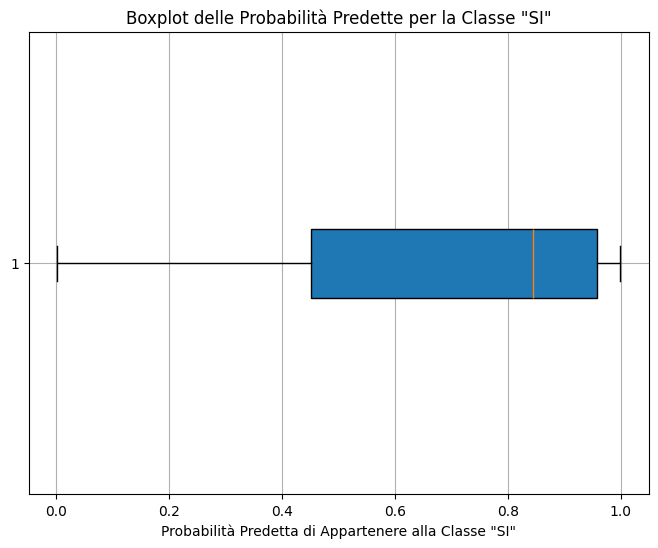

In [165]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()

Balanced Boosting con Cost-Sensitive Learning

In [274]:
X = df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y = df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1}) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_res = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

X_train_res = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)
X_train_res, X_test = X_train.align(X_test, join='inner', axis=1)

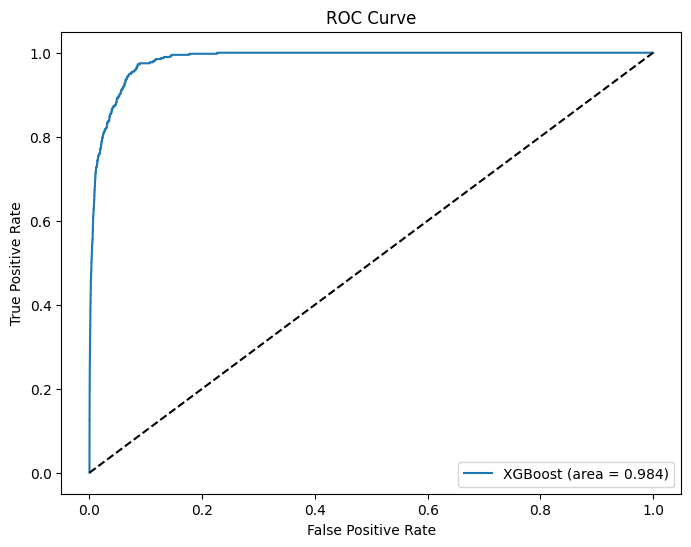

In [275]:
scale_pos_weight = len(y[y == 0]) / len(y[y == 1]) # sbilanciamento tra le classi

model = xgb.XGBClassifier(
    objective='binary:logistic', 
    scale_pos_weight=scale_pos_weight, 
    use_label_encoder=False, 
    eval_metric='logloss'
)

model.fit(X_train_res, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calcolo della curva ROC e dell'AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# Visualizzazione della curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='XGBoost (area = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  # Linea diagonale tratteggiata
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [281]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3) #cambiamo lo split per vedere se i nostri dati overfittano
X_train = pd.get_dummies(X_train) 
X_test = pd.get_dummies(X_test)

missing_columns_train = set(X_train_res.columns) - set(X_train.columns)
for col in missing_columns_train:
    X_train[col] = 0

missing_columns_test = set(X_train_res.columns) - set(X_test.columns)
for col in missing_columns_test:
    X_test[col] = 0

X_train = X_train[X_train_res.columns]
X_test = X_test[X_train_res.columns]

X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

# prediction usando il nostro classifier
y_pred_proba = model.predict_proba(X_test)[:, 1]

results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': y_pred_proba

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

        y_test  y_pred_proba
4377         1      0.999978
27147        1      0.999884
58339        1      0.999832
743          0      0.999820
13906        1      0.999818
...        ...           ...
194832       0      0.000395
51432        0      0.000395
27841        0      0.000394
33739        0      0.000394
13335        0      0.000394

[10000 rows x 2 columns]


In [282]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 382
Numero di 'SI: nel nostro test set 383


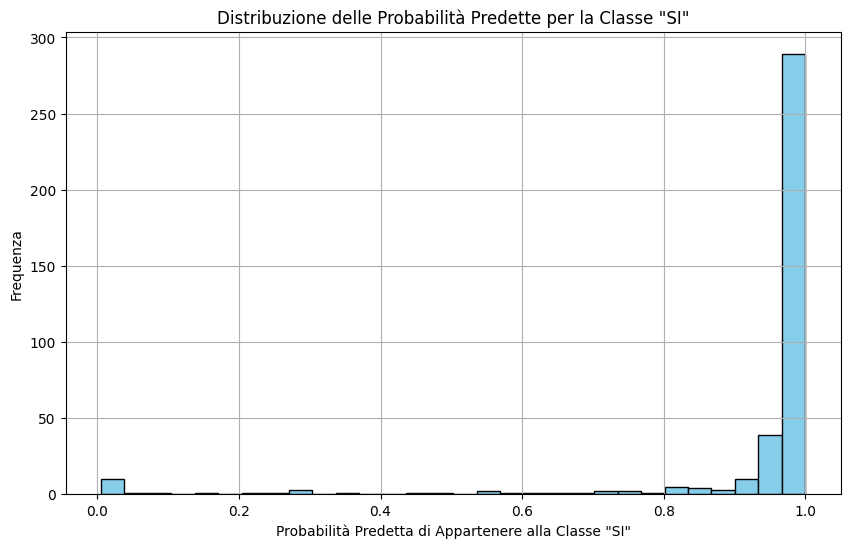

In [268]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

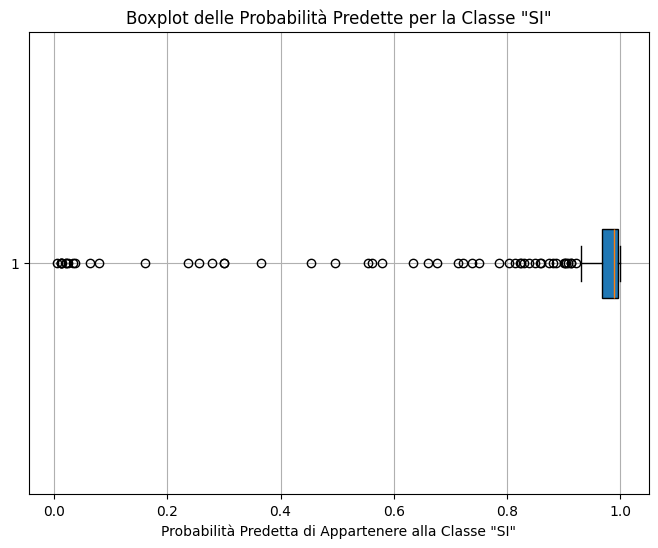

In [278]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()

E' un peccato perchè sarebbe stato semplice da implementare su Optuna, il problema è che sbaglia completamente gli ultimi valori. Se la nostra soglia di 10k dovesse scendere, utilizzerei questo metodo in quanto riesce ad essere molto sicuro sui 'si' e prenderli, quindi anche su 1k ne riesce a prendere il 90%

Dopo aver testato alcune tecniche per trattare i dati sbilanciati, abbiamo scelto l'UnderSampling come piu' performante in quanto riesce ad ottenere gli stessi risultati nonostante il costo computazionale sia migliore.
Andremo a considerare il parametro di soglia del sampling come hyperparametro di tuning 

E' un peccato non esser riusciti ad usare alcune tecniche di Sampling come SMOTE per quanto riguarda l'OverSampling e TomekLinks per l'UnderSampling: entrambi usano k-nearest-neighbors rispettivamente per creare nuovi campioni sintetici e rimuovere campioni di classi diversi quando sono vicini, in modo da facilitare la classificazione.
Abbiamo provato anche ad utilizzare il clustering per cercare di migliorare il bilanciamento del modello, ma da questo punto di vista i dati mancanti non ci aiutano e rendono impossibile provare altre tecniche.

Va fatto un trade off tra la perdita di informazione che otteniamo nel trattare i dati mancanti (invece di darli direttamente in pasto ai modelli di boosting) e l'informazione guadagnata nell'applicare metodi piu' sofisticati di bilanciamento dei dati. Abbiamo valutato la qualità dei nostri dati come piu' importante